In [1]:
"""
@author: Maziar Raissi
"""

import imp
import sys
#sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from cmath import exp,atan
np.random.seed(1090)
tf.set_random_seed(1090)

c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorf

11

In [31]:
from cmath import e


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, u, layers):
        
        X = np.concatenate([x, y, t], 1)
        
        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X
        
        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]
        
        self.u = u
        
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases, self.a = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable(0.1,dtype=tf.float32)
        self.lambda_2 = tf.Variable(0.1, dtype=tf.float32)
        self.lambda_3 = tf.Variable(0.1, dtype=tf.float32)
        #self.lambda_4 = tf.Variable(0.1, dtype=tf.float32)
        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.u_pred ,self.f_pred, self.f2_pred, self.f3_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)
        
        self.loss = tf.reduce_sum(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_sum(tf.square(self.f_pred))+\
                    tf.reduce_sum(tf.square(self.f2_pred))+\
                         tf.reduce_sum(tf.square(self.f3_pred))
                        
                    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        
        a = tf.Variable(0.2, dtype=tf.float32)
        return weights, biases, a
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases, a):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(a*5*tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        lambda_3 = self.lambda_3
        #lambda_4 = self.lambda_4
        u = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases, self.a)
                
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        f3_u=4*tf.exp(x+y+t)/((tf.exp(2*t))+tf.exp(2*x+2*y))-u_y
        
        f2_u=4*tf.exp(x+y+t)/((tf.exp(2*t))+tf.exp(2*x+2*y))-u_x
        s= 4*(tf.exp(9+x+y)-tf.exp(3+3*x+3*y))/tf.square(pow(e,6)+tf.exp(2*(x+y)))
        f_u =s-lambda_1*u_xx-lambda_2*u_yy+lambda_3*tf.sin(u)
        print("ok")
        return u, f_u, f2_u, f3_u
    
    def callback(self, loss, lambda_1, lambda_2, lambda_3):
        #print('Loss: %.3e, l1: %.3f, l2: %.5f, l3:%.5f, l4:%.5f' % (loss, lambda_1, lambda_2, lambda_3, lambda_4))
        return loss
      
    def train(self, nIter): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.u_tf: self.u}
        
        MSE_history=[]
        a_history=[]
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            a_value = self.sess.run(self.a, tf_dict)
            MSE_history.append(loss_value) 
            lambda_1_value = self.sess.run(self.lambda_1)
            lambda_2_value = self.sess.run(self.lambda_2)
            lambda_3_value = self.sess.run(self.lambda_3)
            #lambda_4_value = self.sess.run(self.lambda_4)
            # Print
            if it % 10 == 0:     
                a_history.append(a_value)           
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.3f, l3:%.3f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, lambda_3_value))#,lambda_4_value))
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2, self.lambda_3],#, self.lambda_4
                                loss_callback = self.callback) 
        return MSE_history, a_history
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)

        return u_star

def plot_solution(X_star, u_star, index):
    
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
    
    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()
    
    
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)
        

In [36]:
N_train = 500
layers = [3,20,20,20,20,1]
data = scipy.io.loadmat('D:\LOVESTUDY\paddle\inverse\sine-gordon.mat')
x = data['x']
y = data['y']
t = data['t']
u = data['U']
#print(u.shape)
[X,Y,T]=np.meshgrid(x,y,t)
XYT_star = np.hstack((X.flatten()[:,None],Y.flatten()[:,None],T.flatten()[:,None]))
#print(XYT_star)
idx = np.random.choice(31*141*141, N_train, replace=False)

x_train = XYT_star[:,0].flatten()[:,None][idx,:]
y_train = XYT_star[:,1].flatten()[:,None][idx,:]
t_train = XYT_star[:,2].flatten()[:,None][idx,:]
u_train = u.flatten()[:,None][idx,:]
#print(y_train)
#print(x_train[99],y_train[99],t_train[99],u_train[99])


In [35]:
print("start train")
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, layers)
MSE_hist, a_hist=model.train(3500)
lambda_1_value = model.sess.run(model.lambda_1)

start train
ok
It: 0, Loss: 7.203e+03, l1: 0.101, l2: 0.101, l3:0.101
It: 10, Loss: 6.304e+03, l1: 0.094, l2: 0.098, l3:0.097
It: 20, Loss: 5.099e+03, l1: 0.083, l2: 0.088, l3:0.086
It: 30, Loss: 3.701e+03, l1: 0.071, l2: 0.076, l3:0.074
It: 40, Loss: 2.641e+03, l1: 0.057, l2: 0.062, l3:0.061
It: 50, Loss: 2.256e+03, l1: 0.043, l2: 0.047, l3:0.049
It: 60, Loss: 2.103e+03, l1: 0.030, l2: 0.031, l3:0.038
It: 70, Loss: 1.903e+03, l1: 0.021, l2: 0.018, l3:0.028
It: 80, Loss: 1.720e+03, l1: 0.015, l2: 0.009, l3:0.019
It: 90, Loss: 1.524e+03, l1: 0.010, l2: 0.002, l3:0.010
It: 100, Loss: 1.290e+03, l1: 0.007, l2: -0.002, l3:0.002
It: 110, Loss: 1.007e+03, l1: 0.005, l2: -0.006, l3:-0.006
It: 120, Loss: 6.805e+02, l1: 0.006, l2: -0.009, l3:-0.013
It: 130, Loss: 3.852e+02, l1: 0.013, l2: -0.007, l3:-0.019
It: 140, Loss: 1.835e+02, l1: 0.025, l2: -0.000, l3:-0.024
It: 150, Loss: 8.301e+01, l1: 0.032, l2: 0.001, l3:-0.027
It: 160, Loss: 4.823e+01, l1: 0.024, l2: -0.011, l3:-0.029
It: 170, Loss: 

In [61]:
from cmath import atan, exp


print(4*atan(exp(x_train[90]+y_train[90]-t_train[90])))
u_train[90]

(0.0894681645921744+0j)


array([0.08946816])

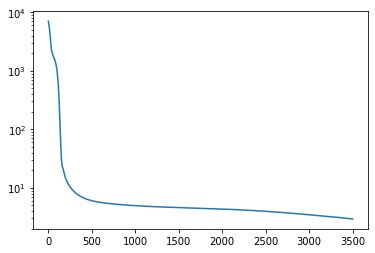

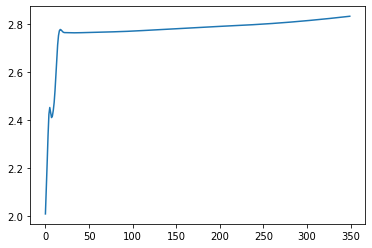

In [69]:
plt.figure(1)
plt.yscale('log')
plt.plot(MSE_hist)
plt.figure(2)
plt.plot(np.array(a_hist)*10)

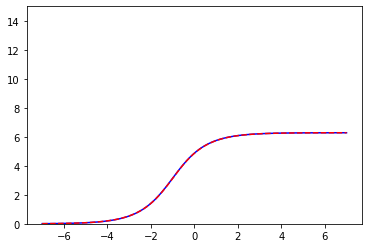

In [70]:
y=np.linspace(-7, 7, 100)
x=4*np.ones(100)
t=3*np.ones(100)
a=model.predict(x.flatten()[:,None],y.flatten()[:,None],t.flatten()[:,None])

exat = 4*np.arctan(np.exp(x+y-t))
plt.ylim(0,15)
plt.plot(y,exat,'b')
plt.plot(y,a,'r--')



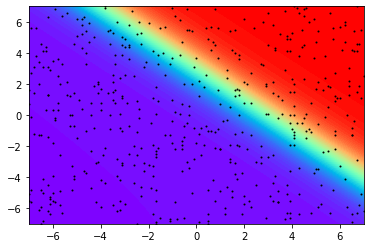

In [68]:
y=np.linspace(-7, 7, 100)
x=np.linspace(-7, 7, 100)
[X,Y]=np.meshgrid(x,y)
t=3*np.ones(10000)
a=model.predict(X.flatten()[:,None],Y.flatten()[:,None],t.flatten()[:,None])
plt.contourf(X,Y,a.reshape(100,100),100,cmap = plt.cm.rainbow)
plt.scatter(x_train,y_train,1,'black')


In [71]:
noise = 0.08        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
print("start train")
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, layers)
MSE_hist, a_hist=model.train(3500)

start train
ok


In [91]:
N_train = 200
layers = [3,20,20,20,20,2]
data = scipy.io.loadmat('D:\LOVESTUDY\paddle\inverse\sine-gordon_t0f.mat')
x = data['x']
y = data['y']
t = np.zeros(141*141)
u = data['u0'].flatten()
g = data['g0'].flatten()
[X,Y]=np.meshgrid(x,y)
XYT0_star = np.hstack((X.flatten()[:,None],Y.flatten()[:,None],t.flatten()[:,None]))

idx = np.random.choice(141*141, N_train, replace=False)
x_train = XYT0_star[:,0].flatten()[:,None][idx,:]
y_train = XYT0_star[:,1].flatten()[:,None][idx,:]
t_train = XYT0_star[:,2].flatten()[:,None][idx,:]
u_train = u.flatten()[:,None][idx,:]
g_train = g.flatten()[:,None][idx,:]



[3.6] [-4.1] [0.] [2.1808305]


In [120]:
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, g_train, layers)
model.train(200000)

TypeError: __init__() takes 6 positional arguments but 7 were given

In [51]:
data = scipy.io.loadmat('D:\LOVESTUDY\paddle\inverse\cylinder_nektar_wake.mat')
    
x = data

        
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1 T=31
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1



array([[ 0. ],
       [ 0.1],
       [ 0.2],
       ...,
       [19.7],
       [19.8],
       [19.9]])